In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [12]:
import tensorflow as tf

In [13]:
import scipy.fftpack

def smooth_data(data, window):
    return np.convolve(y, np.ones(window)/window, mode='same')

# Importing and cleaning data
df = pd.read_csv("short_term_rates.csv")
df1 = df.iloc[:, [0, 4]]
df1 = df1.iloc[5:, :]
df1["Series Description"] = pd.to_datetime(df1["Series Description"])
df1.iloc[:, 1] = pd.to_numeric(df1.iloc[:, 1], errors="coerce")
df1 = df1.dropna()
df1.iloc[:, 1] = df1.iloc[:, 1].astype('float64')

In [14]:
size = 500
padding = 50
total_len = len(df1)
margin = 10

real_x = df1.iloc[:, 0].values
real_y = df1.iloc[:, 1].values

real_

In [32]:
def time_diff(x1, x2):
    diff = x2 - x1
    diff = diff / np.timedelta64(1, 'D')
    return diff

train_x = []
train_y = []

a_list = []
ab_list = []
sigma_list = []

for i in range(padding, total_len - padding - margin):
    start = i - padding
    end = i + size + padding

    x = real_x[start: end]
    y = real_y[start:end]
    smooth_y = smooth_data(y,padding)
    smooth_y = smooth_y[padding:-1 * padding]
    x = x[padding:-1 * padding]
    y = y[padding:-1 * padding]
    
    total_days_diff = time_diff(x[0], x[len(x) - 1])
    dt = 1 / total_days_diff
    deltaT = (np.diff(x) / np.timedelta64(1, 'D')) * dt
    deltaR = np.diff(smooth_y)
    R = smooth_y[: -1]
    Rdt = R * deltaT
    
    A = np.column_stack([deltaT, Rdt])
    AT = A.T

    AT_A = AT @ A
    AT_A = AT_A.astype(float)
    inverse_AT_A = np.linalg.inv(AT_A)
    p = (inverse_AT_A @ AT)
    parameters = p @ deltaR
    
    a = -parameters[1]  
    ab = parameters[0]
    a_list.append(a)
    ab_list.append(ab)
    
    diffy = y - smooth_y
    abssum = np.sum(np.abs(diffy)) / size
    sigma = abssum / np.sqrt(dt)
    sigma_list.append(sigma)
    
    train_x.append(real_y[i:i+size].tolist())
    train_y.append([a, ab, sigma])


In [34]:
train_y

[[-1.2282111847745498, -3.4479952870410706, np.float64(1.0536323823810299)],
 [-1.224840211425898, -3.433221102942115, np.float64(1.054173861835857)],
 [-1.2038165092884556, -3.3549175805337157, np.float64(1.0510476064328225)],
 [-1.2009017931097592, -3.3424415434506423, np.float64(1.0481600535865527)],
 [-1.1705104245810751, -3.242912890891111, np.float64(1.0470046738539442)],
 [-1.1657003623167146, -3.2241711036277207, np.float64(1.0461383067262207)],
 [-1.1595034830110813, -3.201056647861704, np.float64(1.0416440272511547)],
 [-1.1310351051013872, -3.0988793022457215, np.float64(1.0353769544693585)],
 [-1.0596773052035355, -2.8689126409450467, np.float64(1.035017688658587)],
 [-1.0509866336747362, -2.837555287733694, np.float64(1.0311380520570481)],
 [-1.0403727385648374, -2.8001312719903764, np.float64(1.0285913632264292)],
 [-1.0310030836562076, -2.7670177946025616, np.float64(1.0262830878182507)],
 [-1.001645853578717, -2.6639853262277597, np.float64(1.0233579981040475)],
 [-0.94

In [43]:
cleaned_x = []
cleaned_y = []
for i in range(len(train_x)):
    if len(train_x[i]) == 500:
        cleaned_x.append(train_x[i])
        cleaned_y.append(train_y[i])

In [44]:
len(cleaned_x)

15207

In [45]:
len(cleaned_y)

15207

In [40]:
lengths = [len(row) for row in cleaned_data]
print("Min length:", min(lengths))
print("Max length:", max(lengths))
print(len(cleaned_data))

Min length: 500
Max length: 500
15207


In [46]:
# Model normalization

import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

cleaned_x = np.array(cleaned_x)
cleaned_y = np.array(cleaned_y)

In [37]:
lengths = [len(row) for row in train_x]
print("Min length:", min(lengths))
print("Max length:", max(lengths))


Min length: 61
Max length: 500


In [58]:
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()
scaled_x = scaler_x.fit_transform(cleaned_x)
scaled_y = scaler_y.fit_transform(cleaned_y)

In [59]:
print(scaled_x.max())
print(scaled_x.min())
print(scaled_y.max())
print(scaled_y.min())

0.9999999999999999
0.0
1.0
0.0


In [60]:
# actual model 
from tensorflow.keras import layers, models
import numpy as np

model = models.Sequential([
    layers.Input(shape=(500,)),
    layers.Dense(256, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(3)  # Final layer with 3 outputs
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])


In [61]:
history = model.fit(cleaned_x, cleaned_y, validation_split=0.25, epochs=20, batch_size=64)

Epoch 1/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 28.4873 - mae: 2.9798 - val_loss: 6.3115 - val_mae: 1.2191
Epoch 2/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 18.5863 - mae: 2.3670 - val_loss: 3.2664 - val_mae: 0.9451
Epoch 3/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 11.4414 - mae: 1.8954 - val_loss: 2.8587 - val_mae: 0.9357
Epoch 4/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 9.4874 - mae: 1.7898 - val_loss: 3.1141 - val_mae: 1.0055
Epoch 5/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 8.3468 - mae: 1.6577 - val_loss: 2.5780 - val_mae: 0.9688
Epoch 6/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 6.4250 - mae: 1.4797 - val_loss: 3.6660 - val_mae: 1.1052
Epoch 7/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 7.0231 - mae: 1.5086 - val_loss: 3.0442 - val_mae: 1.0676
Epoch 8/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 5.4776 - mae: 1.3641 - val_loss: 3.0066 - val_mae: 1.0723
Epoch 9/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step -

In [74]:
sample_test = scaled_x[10000:10001]
len(sample_test)

1

In [75]:

sample_output = model.predict(sample_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


In [76]:
sample_output

array([[ 0.9411121 ,  0.45546764, -0.14718539]], dtype=float32)

In [77]:
pred_original = scaler_y.inverse_transform(sample_output)

In [78]:
pred_original

array([[ 8.137515 ,  4.1757684, -1.8712689]], dtype=float32)

In [79]:
def V_Model(sigma=0.1, a=0.1, b=0.041, R_initial=0.04, dt=0.001, total_time=1):
    R = [R_initial]
    W = [0]
    t_inc = int(total_time / dt)
    T = [dt*i for i in range(t_inc)]

    for i in range(t_inc - 1):
        dW = np.random.normal()*np.sqrt(dt)
        W.append(W[i] + dW)
        dR = a * (b - R[i])*dt + sigma*dW
        R.append(R[i] + dR)
        
    return R, W, T

def V_Model_with_ab(sigma, a, ab, R_initial, dt, total_time=1):
    R = [R_initial]
    W = [0]
    t_inc = int(total_time / dt)
    T = [dt*i for i in range(t_inc)]

    for i in range(t_inc - 1):
        dW = np.random.normal()*np.sqrt(dt)
        W.append(W[i] + dW)
        dR = (ab[i] - a[i] * R[i])*dt + sigma*dW
        R.append(R[i] + dR)
        
    return R, W, T

In [82]:
actual = scaler_x.inverse_transform(sample_test)


In [85]:
y1 = actual[0][0]
y1

np.float64(2.44)

In [87]:


R1, _, T = V_Model(pred_original[0][2], pred_original[0][0], pred_original[0][1], R_initial=y1, dt=1/size, total_time=1)

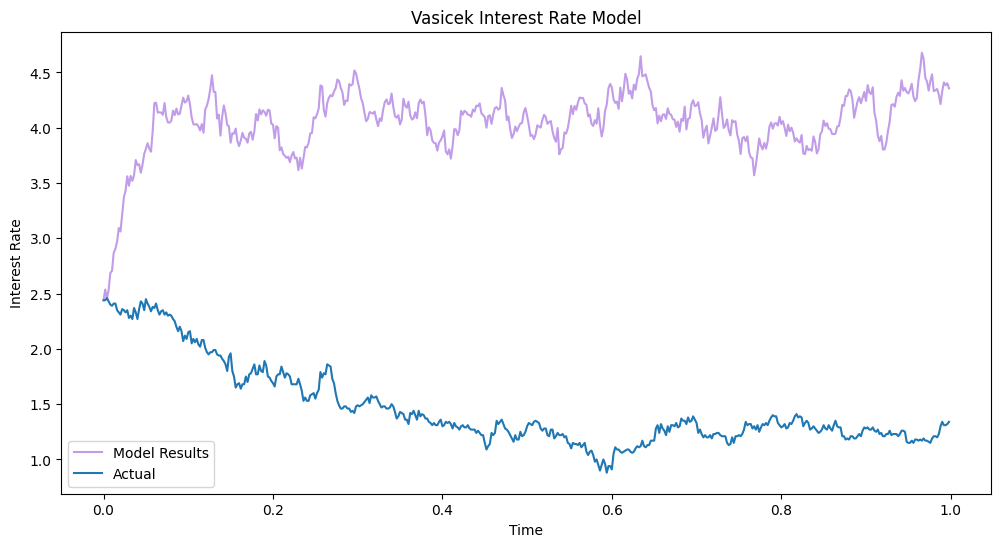

In [88]:
normalized = [1/size * i for i in range(500)]

plt.figure(figsize=(12, 6))
plt.plot(T, R1, label="Model Results", color='#c19ce9')
plt.plot(normalized, actual[0], label="Actual")
plt.xlabel("Time")
plt.ylabel("Interest Rate")
plt.title(label="Vasicek Interest Rate Model")
plt.legend()
plt.show()

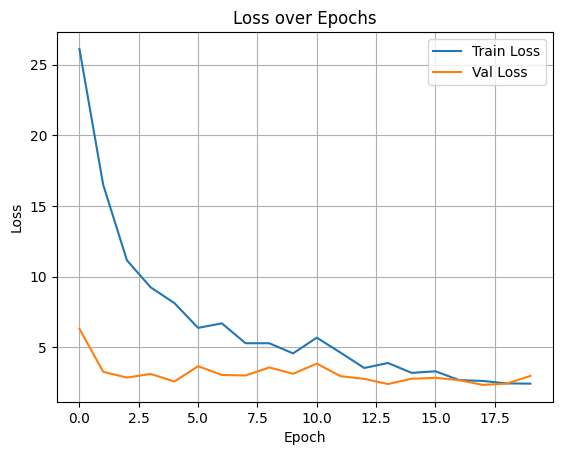

In [89]:
import matplotlib.pyplot as plt

# Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

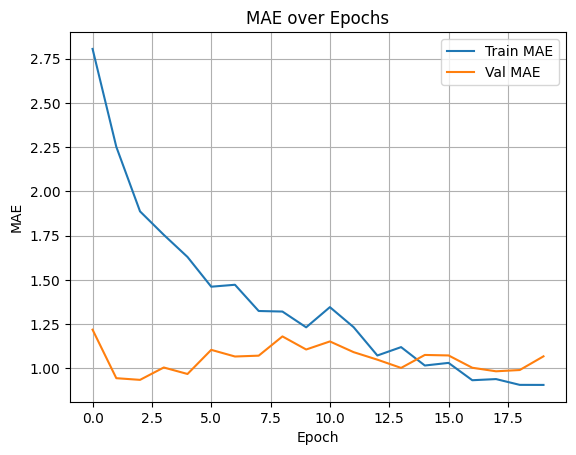

In [90]:
# MAE (or any other metric)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Val MAE')
plt.title('MAE over Epochs')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.grid(True)
plt.show()